# 3. Übung Geodatenanalyse
## Analyse von Bewegungsdaten II

In der heutigen Übung werden Sie aus GPS-Trackingdaten trajektorien extrahieren und diese anschliessend analysieren. Die Übung knüpft dabei direkt an die Übung 2 an und besteht aus folgenden teilen: 

- __Teil 1:__ Validierung der Ergebnisse aus Übung 2 (Extrahierung von Aufenthaltspunkten).
- __Teil 2:__ Implementierung eines Algorithmus zur Segmentierung von trajektorien basierend auf bereits extrahierten Aufenthaltspunkten. 
- __Teil 3:__ Analyse der Trajektorien über Histogramme und durch die mittles Merkmalberechnung und über Clustering mit ähnlichkeitsmaasen (Fréchet Distanz)



In [1]:
import datetime
import pyproj

import numpy as np
import ipyleaflet as ipy 
import geopandas as gpd
import json
import pandas as pd
import os
from gda_sdm2_functions import read_romataxidata, apply_dbscan, transform, filter_by_label

from ipywidgets import HTML
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import matplotlib
import time



## Validierung der Ergebnisse aus Übung 2

### 2.1 Berechnen der Ergebnisse der letzten Übung
Zuerst berechnen wir die Ergebnisse aus Übung 2 erneut. Dafür haben wir die Funktionen die Sie in Übung 2 bearbeitet haben in der Datei ``gda_sdm2_functions.py`` zusammengefasst. 


In [2]:
# Path to input file
input_file = os.path.join('input_data', 'taxi_21.txt')

# Read data
data_orginal = read_romataxidata(input_file, nrows=5000)

# Apply transformations
data = transform(data_orginal, timescale=60)

# Calculate clusters with dbscan
labels, core_samples_indices = apply_dbscan(data, eps=5, min_samples=10, metric='chebyshev')

Estimated number of clusters: 47


### 2.2 Visualisierung der Staypoints
Um uns die Daten der letzten Woche nochmals genauer anzusehen, möchten wie sie Visualsieren. Dazu fassen wir die Daten in einem [Geopandas Dataframe](https://github.com/geopandas/geopandas) zusammen. Ein Geodataframe ist eine python Datenstruktur die es uns ermöglicht effizient mit Geodaten umzugehen und sie später zu visualisieren. Alle Daten die wir visualsieren möchten, müssen also in dem Geodataframe stehen. Um die Ergebnisse gut analysieren zu können und um später mit den Daten weiterarbeiten zu könenn, brauchen wir vor allem die folgenden Informationen:
- __Geometrie__
- __Zeitstempel__
- __Clusterlabel__ 
- __Kernpunktindikator__

Dafür verbinden wir die Originaldaten (nicht die transformierten Daten, diese haben keine Zeitstempel mehr) mit den Ergebnissen des Cluteringalgorithmus.


In [3]:
# Construct Geodataframe from original data
italy_gdf = gpd.GeoDataFrame(data=data_orginal, columns= ['long', 'lat',  'timestamp'], 
            geometry=gpd.points_from_xy([row[0] for row in data_orginal], [row[1] for row in data_orginal]), crs="EPSG:4326")

# Add clustering information
italy_gdf['is_core'] = False
italy_gdf.loc[core_samples_indices, 'is_core'] = True
italy_gdf['label'] = labels.astype('int')

# make sure the dataframe is sorted by tracking time and show first lines
italy_gdf.sort_values(by='timestamp', inplace=True)
italy_gdf.head()

,long,lat,timestamp,geometry,is_core,label
0,12.524926,41.936760,2014-02-02 14:32:17.886734,POINT (12.52493 41.93676),False,-1
1,12.524926,41.936760,2014-02-02 14:32:17.887344,POINT (12.52493 41.93676),False,-1
2,12.523382,41.935415,2014-02-02 14:32:25.942641,POINT (12.52338 41.93541),False,-1
3,12.521539,41.933817,2014-02-02 14:32:40.983523,POINT (12.52154 41.93382),False,-1
4,12.521023,41.933368,2014-02-02 14:32:56.936338,POINT (12.52102 41.93337),False,-1


In [83]:
print(italy_gdf['label'].unique())

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


Die Daten im Geopandasformat geben uns schon jetzt die Möglichkeit sie einfach und schnell über die ``gdf.plot()`` zu visualisieren. Um die Ergbnisse gut zu verstehen, ist es aber hilfreich, die Ergebnisse interaktiv auf einer Karte darzustellen.

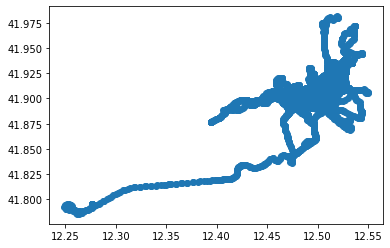

In [4]:
italy_gdf.plot()

In [99]:
def get_ipyleaflet_trackpoint_layer(gdf, min_label=0, max_label=1, slack=0):
    
       
    circlelist_noise = list()
    circlelist_sp = list()
    
    
    gdf = filter_by_label(gdf, min_label, max_label, slack=slack)
    print(gdf.shape)

    
    # create colormap
    unique_labels = gdf['label'].unique().tolist()
    nb_labels = len(unique_labels)
    unique_labels.remove(-1)
    true_min_label = min(unique_labels)

    colors = plt.cm.Spectral(np.linspace(0, 1, nb_labels))
    colors = [matplotlib.colors.to_hex(color_this) for color_this in colors]
    
    for ix, row in gdf.iterrows():
        
        message = HTML()
        t_string = row['timestamp'].strftime("%Y-%m-%d %H-%M-%S")
        
        message.value = """<table>
                            <tr> <td>label:</td>      <td>&emsp;</td> <td>{}</td> </tr>
                            <tr> <td>timestamp:</td>  <td>&emsp;</td> <td>{}</td> </tr>
                            </table>""".format(row.label, t_string)
        
        if int(row.label) == -1:
            fillcolor_this = "Gray"
            opacity_this = 0.6
            stroke = True
            radius_this = 5
       

            circle = ipy.CircleMarker()
            circle.location = (row.geometry.y, row.geometry.x)
            circle.radius = radius_this
            circle.fill_opacity = opacity_this
            circle.fill_color = fillcolor_this
            circle.stroke = stroke
            circle.color = 'Black'
            circle.weight = 1
            circle.opacity = 0.3
            circle.popup = message 
            
            circlelist_noise.append(circle)
        
        else:
            fillcolor_this = colors[int(row.label)-true_min_label]
            opacity_this= 0.5
            stroke = True
            radius_this = 7
            circle = ipy.CircleMarker()
            circle.location = (row.geometry.y, row.geometry.x)
            circle.radius = radius_this
            circle.fill_opacity = opacity_this
            circle.fill_color = fillcolor_this
            circle.stroke = stroke
            circle.color = 'Black'
            circle.weight = 1
            circle.opacity = 0.3
            circle.popup = message 
            
            circlelist_sp.append(circle)
            
        
        
       
        #circle_group.append(circle)

    layer_group_noise = ipy.LayerGroup(layers=circlelist_noise)
    layer_group_noise.name = 'trackpoints noise'
    
    layer_group_sp = ipy.LayerGroup(layers=circlelist_sp)
    layer_group_sp.name = 'trackpoints staypoints'
        
    return layer_group_noise, layer_group_sp


                                 



In [100]:
try: 
    del m
except:
    pass
try:
    del layer_group
except:
    pass

In [109]:
m = ipy.Map(center=(41.888, 12.5215), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
m.add_control(ipy.LayersControl())
m

Map(center=[41.888, 12.5215], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [110]:
layer_noise, layer_sp = get_ipyleaflet_trackpoint_layer(italy_gdf.copy(), min_label=6, max_label=8, slack=10)
m.add_layer(layer_noise)
m.add_layer(layer_sp)

(830, 6)


x	y	timestamp_norm	label	geometry	timestamp	is_core
0	294810.534620	4.645718e+06	46952.298112	-1.0	POINT (12.52493 41.93676)	2014-02-02 14:32:17.886734

In [77]:
italy_gdf.sort_values(by='timestamp', inplace=True)
input_raw = italy_gdf[['x', 'y', 'timestamp', 'label', 'geometry']].values.tolist()
input_raw[0]

KeyError: "['x', 'y'] not in index"

In [ ]:
def get_tripleg_geometry_from_points(list_of_points):
    coords = [(point.x, point.y) for point in list_of_points]
    
    return LineString(coords)
    
    
def get_tripleg(cluster_start, cluster_end, start_time, end_time, geometry):
    tripleg_dict =  {'cluster_start': cluster_start, 
                     'cluster_end': cluster_end,
                    't_start': start_time, 
                     't_end': end_time, 
                     'geometry': geometry}
    
    return tripleg_dict

    
    
    


n = len(input_raw)
tripleg_list = []
skip_k_trackpoints = 0

for i in range(0,n):
    
    if skip_k_trackpoints > 0:
        skip_k_trackpoints = skip_k_trackpoints -1
        continue
    
    
    if input_raw[i][3] == -1:
        # begin of tripleg
        print(i)
        
        tripleg_start_cluster = input_raw[i-1][3]
        tripleg_start_time = input_raw[i][2]
        tripleg_point_list = []
        for j in range(i,n):
            
            if input_raw[j][3] == -1:
                tripleg_point_list.append(input_raw[j][4])            
                
            # end of tripleg
            else:
                if len(tripleg_point_list) > 1:

                    tripleg_geometry_this = get_tripleg_geometry_from_points(tripleg_point_list)
                    tripleg_end_time = input_raw[j-1][2]
                    
                    tripleg_end_cluster = input_raw[j][3]

                    tripleg_this = get_tripleg(cluster_start=tripleg_start_cluster,
                                               cluster_end=tripleg_end_cluster,
                                                start_time=tripleg_start_time,
                                               end_time=tripleg_end_time,
                                               geometry=tripleg_geometry_this)

                    tripleg_list.append(tripleg_this)
                    skip_k_trackpoints = len(tripleg_point_list)


                break
                
    else:
        continue



            

In [ ]:
tripleg_gdf = pd.DataFrame(tripleg_list)
tripleg_gdf = gpd.GeoDataFrame(tripleg_gdf, geometry=tripleg_gdf.geometry, crs=crs_wgs84)
tripleg_gdf['t_start'] = tripleg_gdf['t_start'].dt.strftime("%Y-%m-%d %H-%M-%S")
tripleg_gdf['t_end'] = tripleg_gdf['t_end'].dt.strftime("%Y-%m-%d %H-%M-%S")

In [ ]:
m = ipy.Map(center=(41.8881987655463, 12.5215863435528), zoom = 12) # basemap= ipy.basemaps.Esri.WorldTopoMap)
m.add_control(ipy.LayersControl())


In [ ]:
min_label = 0
max_label = 1
layer_group = get_trackpoint_layer(italy_gdf, min_label=min_label, max_label=max_label)
m.add_layer(layer_group)

In [ ]:
geo_data = ipy.GeoData(geo_dataframe=filter_by_label(tripleg_gdf, min_label, max_label, label_col_name='cluster_start'),
                       name='triplegs', style={'opacity': 0.8, 'width': 8, 'color': 'Blue'}, 
                       hover_style={'color': '#b08a3e' , 'fillOpacity': 0.8})

from ipyleaflet import WidgetControl
html = HTML("")
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
m.add_control(control)
m.add_layer(geo_data)

In [ ]:
def update_html_tripleg(feature, **kwargs):
    string_list = []
    string_list.append("<table>")
    for var_name in feature['properties']:
        value = feature['properties'][var_name]
        string_list.append("<tr> <td>{}:</td>  <td>&emsp;</td> <td>{}</td> </tr>\n".format(var_name, value))
   
    string_list.append("</table>")
    html.value = "".join(string_list)



geo_data.on_hover(update_html_tripleg)


In [ ]:
m

In [ ]:
# calculate speed + histogram

In [ ]:
D_frechet = StandardScaler().fit_transform(calculate_distance_matrix(gdf, distance='frechet'))